# 3D classification example based on DenseNet

This tutorial shows an example of 3D classification task based on DenseNet and array format transforms.

Here, the task is given to classify MR images into male/female.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_classification/torch/densenet_training_array.ipynb)

## Setup environment

In [1]:
# !python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import shutil
import tempfile

import time
start=time.time()

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
#Provides an iterable over the given `dataset`.  It inherits the PyTorch. DataLoader and adds enhanced `collate_fn` and `worker_fn` by default.
#https://docs.monai.io/en/stable/_modules/monai/data/dataloader.html
from monai.transforms import (
    AddChannel,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    EnsureType
)

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO) #imported module, check what is doing in documentation
print_config() #imported from monai, check what is doing in documentation

MONAI version: 0.9.0
Numpy version: 1.21.6
Pytorch version: 1.12.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
import wandb

wandb.login()
wandb.init(project="monai", entity="nsourlos",name="monai_3D_classification")

wandb: Currently logged in as: nsourlos. Use `wandb login --relogin` to force relogin


In [5]:
# Set data directory
directory=os.getcwd()
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content


In [6]:
# IXI dataset as a demo, downloadable from https://brain-development.org/ixi-dataset/
images = [
    os.sep.join([root_dir, "ixi", "IXI314-IOP-0889-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI249-Guys-1072-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI609-HH-2600-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI173-HH-1590-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI020-Guys-0700-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI342-Guys-0909-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI134-Guys-0780-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI577-HH-2661-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI066-Guys-0731-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI130-HH-1528-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI607-Guys-1097-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI175-HH-1570-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI385-HH-2078-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI344-Guys-0905-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI409-Guys-0960-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI584-Guys-1129-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI253-HH-1694-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI092-HH-1436-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI574-IOP-1156-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI585-Guys-1130-T1.nii.gz"]),
]

# 2 binary labels for gender classification: man or woman
labels = np.array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

In [7]:
if not os.path.isfile(images[0]):
    resource = "http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar"
    md5 = "34901a0593b41dd19c1a1f746eac2d58"

    dataset_dir = os.path.join(root_dir, "ixi")
    tarfile_name = f"{dataset_dir}.tar"

    download_and_extract(resource, tarfile_name, dataset_dir, md5) #imported from monai, check exactly what is doing in documentation

In [8]:
from monai.utils import set_determinism
set_determinism(seed=0) # Set deterministic training for reproducibility

In [9]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam','sgd']
        },
    'max_epochs': {
        'values': [4,5,6] #,8,10
        },
    'lr': {
        'values': [1e-5,1e-4] #1e-6,
        },
    # 'fc_layer_size': {
    #     'values': [128, 256, 512]
    #     },
    # 'dropout': {
    #       'values': [0.5] #0.3, 0.4,
    #     },
    }

sweep_config['parameters'] = parameters_dict

In [10]:
sweep_id = wandb.sweep(sweep_config, project="monai_3D_classification_sweeps_random")

Create sweep with ID: rehbb1ci
Sweep URL: https://wandb.ai/nsourlos/monai_3D_classification_sweeps_random/sweeps/rehbb1ci


In [11]:
# Define transforms
train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), RandRotate90(), EnsureType()])

val_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), EnsureType()])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory) #pin_memory is torch.cuda.is_available()

im, label = monai.utils.misc.first(check_loader) #IS IT FOR JUST TO CHECK???
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:10], labels=labels[:10], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

<class 'torch.Tensor'> torch.Size([3, 1, 96, 96, 96]) tensor([[1., 0.],
        [1., 0.],
        [1., 0.]]) torch.Size([3, 2])


In [12]:
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device) #dropout_prob=config.dropout

        optimizer = config.optimizer
        if optimizer=='adam':
              optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        elif optimizer=='sgd':
              optimizer = torch.optim.SGD(model.parameters(), lr=config.lr) #iterable of parameters to optimize or dicts defining parameter groups
       
        max_epochs = config.max_epochs
        val_interval=2

        loss_function = torch.nn.CrossEntropyLoss()
        # loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

        # start a typical PyTorch training

        best_metric = -1
        best_metric_epoch = -1
        epoch_loss_values = []
        metric_values = []
        writer = SummaryWriter()

        for epoch in range(max_epochs):

          print("-" * 10)
          print(f"epoch {epoch + 1}/{max_epochs}")
          model.train()
          epoch_loss = 0
          step = 0

          for batch_data in train_loader:
              step += 1
              inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = loss_function(outputs, labels)
              loss.backward()
              optimizer.step()
              epoch_loss += loss.item()
              epoch_len = len(train_ds) // train_loader.batch_size
              print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
              writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)    
              #keep write (summarywriter of Tensorboard) to compare with wandb below - if not comment import above  
              wandb.log({"train loss": loss.item()})


          epoch_loss /= step
          epoch_loss_values.append(epoch_loss)
          print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
          wandb.log({"epoch_loss": epoch_loss,"epoch":epoch})


          if (epoch + 1) % val_interval == 0:
              model.eval()

              num_correct = 0.0
              metric_count = 0
              for val_data in val_loader:
                  val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                  with torch.no_grad():
                      val_outputs = model(val_images)
                      value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                      metric_count += len(value)
                      num_correct += value.sum().item()

              metric = num_correct / metric_count
              metric_values.append(metric)
              wandb.log({"accur": metric,"epoch":epoch})

              if metric > best_metric:
                  best_metric = metric
                  best_metric_epoch = epoch + 1
                  print("best_metric_model_classification3d_array"+str(config.optimizer)+str(max_epochs)+".pth")
                  torch.save(model.state_dict(), "best_metric_model_classification3d_array"+str(config.optimizer)+str(max_epochs)+".pth")
                  print("saved new best metric model")

              print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
              print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
              writer.add_scalar("val_accuracy", metric, epoch + 1)

              # Save the model in the exchangeable ONNX format
              torch.onnx.export(model, val_images,"model"+str(config.optimizer)+str(max_epochs)+".onnx") 
              wandb.save("model"+str(config.optimizer)+str(max_epochs)+".onnx")

        print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
        writer.close()

wandb.agent(sweep_id, train, count=8) #Run 8 different experiments with random combinations of the parameters defined in the config file

end=time.time()
print("Training took {} secs".format(end-start))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 96xllfrg with config:
wandb: 	lr: 1e-05
wandb: 	max_epochs: 6
wandb: 	optimizer: adam


----------
epoch 1/6
1/5, train_loss: 0.6964
2/5, train_loss: 0.5314
3/5, train_loss: 0.6966
4/5, train_loss: 0.5254
5/5, train_loss: 0.8043
epoch 1 average loss: 0.6508
----------
epoch 2/6
1/5, train_loss: 0.5727
2/5, train_loss: 0.5198
3/5, train_loss: 0.5311
4/5, train_loss: 0.6131
5/5, train_loss: 0.7665
epoch 2 average loss: 0.6006
best_metric_model_classification3d_arrayadam6.pth
saved new best metric model
Current epoch: 2 current accuracy: 0.4000 
Best accuracy: 0.4000 at epoch 2
----------
epoch 3/6
1/5, train_loss: 0.7247
2/5, train_loss: 0.5317
3/5, train_loss: 0.5308
4/5, train_loss: 0.5139
5/5, train_loss: 0.9184
epoch 3 average loss: 0.6439
----------
epoch 4/6
1/5, train_loss: 0.5103
2/5, train_loss: 0.4955
3/5, train_loss: 0.8964
4/5, train_loss: 0.5961
5/5, train_loss: 0.4964
epoch 4 average loss: 0.5990
best_metric_model_classification3d_arrayadam6.pth
saved new best metric model
Current epoch: 4 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 4
----------
e

accur,▁██
epoch,▁▂▂▄▅▅▇██
epoch_loss,█▅█▅▂▁
train loss,▅▂▅▂▆▃▂▂▃▆▅▂▂▂█▂▁█▃▁▃▂▂▂▂▁▁▄▂▁
accur,0.6
epoch,5
epoch_loss,0.52256
train loss,0.46769


wandb: Agent Starting Run: 74mhn68o with config:
wandb: 	lr: 1e-05
wandb: 	max_epochs: 4
wandb: 	optimizer: sgd


----------
epoch 1/4
1/5, train_loss: 0.6529
2/5, train_loss: 0.7545
3/5, train_loss: 0.7620
4/5, train_loss: 0.7549
5/5, train_loss: 0.7571
epoch 1 average loss: 0.7363
----------
epoch 2/4
1/5, train_loss: 0.7723
2/5, train_loss: 0.7072
3/5, train_loss: 0.7522
4/5, train_loss: 0.6222
5/5, train_loss: 0.7569
epoch 2 average loss: 0.7222
best_metric_model_classification3d_arraysgd4.pth
saved new best metric model
Current epoch: 2 current accuracy: 0.4000 
Best accuracy: 0.4000 at epoch 2
----------
epoch 3/4
1/5, train_loss: 0.7692
2/5, train_loss: 0.7435
3/5, train_loss: 0.6520
4/5, train_loss: 0.7606
5/5, train_loss: 0.6373
epoch 3 average loss: 0.7125
----------
epoch 4/4
1/5, train_loss: 0.6417
2/5, train_loss: 0.6509
3/5, train_loss: 0.7675
4/5, train_loss: 0.7674
5/5, train_loss: 0.7659
epoch 4 average loss: 0.7187
best_metric_model_classification3d_arraysgd4.pth
saved new best metric model
Current epoch: 4 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 4
Training compl

accur,▁█
epoch,▁▃▃▆██
epoch_loss,█▄▁▃
train loss,▂▇█▇▇█▅▇▁▇█▇▂▇▂▂▂███
accur,0.6
epoch,3
epoch_loss,0.71869
train loss,0.76593


wandb: Agent Starting Run: zqfb2u28 with config:
wandb: 	lr: 0.0001
wandb: 	max_epochs: 6
wandb: 	optimizer: adam


----------
epoch 1/6
1/5, train_loss: 0.7234
2/5, train_loss: 0.9795
3/5, train_loss: 0.8012
4/5, train_loss: 0.7509
5/5, train_loss: 0.6755
epoch 1 average loss: 0.7861
----------
epoch 2/6
1/5, train_loss: 0.8625
2/5, train_loss: 0.7440
3/5, train_loss: 0.7376
4/5, train_loss: 0.6711
5/5, train_loss: 0.6823
epoch 2 average loss: 0.7395
best_metric_model_classification3d_arrayadam6.pth
saved new best metric model
Current epoch: 2 current accuracy: 0.4000 
Best accuracy: 0.4000 at epoch 2
----------
epoch 3/6
1/5, train_loss: 0.5695
2/5, train_loss: 0.4060
3/5, train_loss: 0.8838
4/5, train_loss: 0.5355
5/5, train_loss: 0.4881
epoch 3 average loss: 0.5766
----------
epoch 4/6
1/5, train_loss: 0.4541
2/5, train_loss: 0.5276
3/5, train_loss: 0.8243
4/5, train_loss: 0.6729
5/5, train_loss: 0.4587
epoch 4 average loss: 0.5875
best_metric_model_classification3d_arrayadam6.pth
saved new best metric model
Current epoch: 4 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 4
----------
e

accur,▁██
epoch,▁▂▂▄▅▅▇██
epoch_loss,█▇▃▃▁▁
train loss,▅█▆▅▄▇▅▅▄▅▃▁▇▃▂▂▃▆▄▂▇▂▁▁▂▂▁▁█▁
accur,0.6
epoch,5
epoch_loss,0.51421
train loss,0.38045


wandb: Agent Starting Run: j1go13st with config:
wandb: 	lr: 0.0001
wandb: 	max_epochs: 4
wandb: 	optimizer: sgd


----------
epoch 1/4
1/5, train_loss: 0.6886
2/5, train_loss: 0.7012
3/5, train_loss: 0.5306
4/5, train_loss: 0.5251
5/5, train_loss: 0.7404
epoch 1 average loss: 0.6372
----------
epoch 2/4
1/5, train_loss: 0.8993
2/5, train_loss: 0.5294
3/5, train_loss: 0.5213
4/5, train_loss: 0.7080
5/5, train_loss: 0.5182
epoch 2 average loss: 0.6352
best_metric_model_classification3d_arraysgd4.pth
saved new best metric model
Current epoch: 2 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 2
----------
epoch 3/4
1/5, train_loss: 0.5112
2/5, train_loss: 0.6815
3/5, train_loss: 0.4962
4/5, train_loss: 0.7279
5/5, train_loss: 0.6872
epoch 3 average loss: 0.6208
----------
epoch 4/4
1/5, train_loss: 0.7211
2/5, train_loss: 0.5114
3/5, train_loss: 0.5060
4/5, train_loss: 0.6764
5/5, train_loss: 0.6740
epoch 4 average loss: 0.6178
Current epoch: 4 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 2
Training completed, best_metric: 0.6000 at epoch: 2


accur,▁▁
epoch,▁▃▃▆██
epoch_loss,█▇▂▁
train loss,▄▅▂▂▅█▂▁▅▁▁▄▁▅▄▅▁▁▄▄
accur,0.6
epoch,3
epoch_loss,0.61779
train loss,0.67404


wandb: Agent Starting Run: oaj21tty with config:
wandb: 	lr: 0.0001
wandb: 	max_epochs: 4
wandb: 	optimizer: adam


----------
epoch 1/4
1/5, train_loss: 0.9809
2/5, train_loss: 0.9095
3/5, train_loss: 0.8544
4/5, train_loss: 0.5920
5/5, train_loss: 0.7009
epoch 1 average loss: 0.8075
----------
epoch 2/4
1/5, train_loss: 0.7356
2/5, train_loss: 0.7195
3/5, train_loss: 0.4545
4/5, train_loss: 0.7429
5/5, train_loss: 0.7683
epoch 2 average loss: 0.6841
best_metric_model_classification3d_arrayadam4.pth
saved new best metric model
Current epoch: 2 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 2
----------
epoch 3/4
1/5, train_loss: 0.8404
2/5, train_loss: 0.6574
3/5, train_loss: 0.2959
4/5, train_loss: 0.8275
5/5, train_loss: 0.6899
epoch 3 average loss: 0.6622
----------
epoch 4/4
1/5, train_loss: 0.2540
2/5, train_loss: 0.6052
3/5, train_loss: 0.5080
4/5, train_loss: 0.8626
5/5, train_loss: 0.9483
epoch 4 average loss: 0.6356
Current epoch: 4 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 2
Training completed, best_metric: 0.6000 at epoch: 2


accur,▁▁
epoch,▁▃▃▆██
epoch_loss,█▃▂▁
train loss,█▇▇▄▅▆▅▃▆▆▇▅▁▇▅▁▄▃▇█
accur,0.6
epoch,3
epoch_loss,0.63561
train loss,0.94831


wandb: Agent Starting Run: rou8pbx3 with config:
wandb: 	lr: 1e-05
wandb: 	max_epochs: 6
wandb: 	optimizer: adam


----------
epoch 1/6
1/5, train_loss: 0.6952
2/5, train_loss: 0.7933
3/5, train_loss: 0.7668
4/5, train_loss: 0.6184
5/5, train_loss: 0.7730
epoch 1 average loss: 0.7293
----------
epoch 2/6
1/5, train_loss: 0.8315
2/5, train_loss: 0.7547
3/5, train_loss: 0.7961
4/5, train_loss: 0.6315
5/5, train_loss: 0.7615
epoch 2 average loss: 0.7551
best_metric_model_classification3d_arrayadam6.pth
saved new best metric model
Current epoch: 2 current accuracy: 0.5000 
Best accuracy: 0.5000 at epoch 2
----------
epoch 3/6
1/5, train_loss: 0.7411
2/5, train_loss: 0.6722
3/5, train_loss: 0.7311
4/5, train_loss: 0.7012
5/5, train_loss: 0.6927
epoch 3 average loss: 0.7077
----------
epoch 4/6
1/5, train_loss: 0.7212
2/5, train_loss: 0.6192
3/5, train_loss: 0.7140
4/5, train_loss: 0.7280
5/5, train_loss: 0.6204
epoch 4 average loss: 0.6806
Current epoch: 4 current accuracy: 0.4000 
Best accuracy: 0.5000 at epoch 2
----------
epoch 5/6
1/5, train_loss: 0.5547
2/5, train_loss: 0.6353
3/5, train_loss: 0.73

accur,█▅▁
epoch,▁▂▂▄▅▅▇██
epoch_loss,▆█▅▄▁▃
train loss,▅▇▆▃▇█▆▇▃▆▆▄▅▅▄▅▃▅▅▃▁▃▆▂▅▃▅▄▄▄
accur,0.3
epoch,5
epoch_loss,0.67141
train loss,0.67972


wandb: Agent Starting Run: blwfulv6 with config:
wandb: 	lr: 0.0001
wandb: 	max_epochs: 6
wandb: 	optimizer: adam


----------
epoch 1/6
1/5, train_loss: 0.7276
2/5, train_loss: 0.6915
3/5, train_loss: 0.6634
4/5, train_loss: 0.8823
5/5, train_loss: 0.5707
epoch 1 average loss: 0.7071
----------
epoch 2/6
1/5, train_loss: 0.5405
2/5, train_loss: 1.1515
3/5, train_loss: 0.5069
4/5, train_loss: 0.4989
5/5, train_loss: 0.9358
epoch 2 average loss: 0.7267
best_metric_model_classification3d_arrayadam6.pth
saved new best metric model
Current epoch: 2 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 2
----------
epoch 3/6
1/5, train_loss: 0.7639
2/5, train_loss: 1.0965
3/5, train_loss: 0.5639
4/5, train_loss: 0.4801
5/5, train_loss: 0.4622
epoch 3 average loss: 0.6733
----------
epoch 4/6
1/5, train_loss: 0.4696
2/5, train_loss: 1.0384
3/5, train_loss: 0.4028
4/5, train_loss: 0.5422
5/5, train_loss: 0.4207
epoch 4 average loss: 0.5747
best_metric_model_classification3d_arrayadam6.pth
saved new best metric model
Current epoch: 4 current accuracy: 0.7000 
Best accuracy: 0.7000 at epoch 4
----------
e

accur,▁██
epoch,▁▂▂▄▅▅▇██
epoch_loss,▇█▇▄▄▁
train loss,▄▄▄▆▃▂█▂▂▆▄█▃▂▂▂▇▁▂▁▃▆▄▁▂▁▁▁▃▃
accur,0.7
epoch,5
epoch_loss,0.47419
train loss,0.60252


wandb: Agent Starting Run: fnelb6gr with config:
wandb: 	lr: 1e-05
wandb: 	max_epochs: 5
wandb: 	optimizer: adam


----------
epoch 1/5
1/5, train_loss: 0.6789
2/5, train_loss: 0.6642
3/5, train_loss: 0.6962
4/5, train_loss: 0.7116
5/5, train_loss: 0.6973
epoch 1 average loss: 0.6896
----------
epoch 2/5
1/5, train_loss: 0.6783
2/5, train_loss: 0.7496
3/5, train_loss: 0.6696
4/5, train_loss: 0.6828
5/5, train_loss: 0.5910
epoch 2 average loss: 0.6743
best_metric_model_classification3d_arrayadam5.pth
saved new best metric model
Current epoch: 2 current accuracy: 0.4000 
Best accuracy: 0.4000 at epoch 2
----------
epoch 3/5
1/5, train_loss: 0.6556
2/5, train_loss: 0.6353
3/5, train_loss: 0.7213
4/5, train_loss: 0.6664
5/5, train_loss: 0.6707
epoch 3 average loss: 0.6699
----------
epoch 4/5
1/5, train_loss: 0.6657
2/5, train_loss: 0.7021
3/5, train_loss: 0.6580
4/5, train_loss: 0.5905
5/5, train_loss: 0.5814
epoch 4 average loss: 0.6396
best_metric_model_classification3d_arrayadam5.pth
saved new best metric model
Current epoch: 4 current accuracy: 0.5000 
Best accuracy: 0.5000 at epoch 4
----------
e

accur,▁█
epoch,▁▃▃▅▆▆█
epoch_loss,█▆▅▁▅
train loss,▅▄▆▆▆▅█▅▅▁▄▃▇▅▅▅▆▄▁▁▃▄▃▆▇
accur,0.5
epoch,4
epoch_loss,0.66769
train loss,0.72516


Training took 564.8179202079773 secs


# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

#### Bounds
If we were to test the occlusion centred on all voxels in our image, we would have to do `torch.prod(im.shape) = 96^3 = ~1e6` predictions. We can use the bounding box to only to the estimations in a region of interest, for example over one slice.

To do this, we simply give the bounding box as `(minC,maxC,minD,maxD,minH,maxH,minW,maxW)`. We can use `-1` for any value to use its full extent (`0` and `im.shape-1` for min's and max's, respectively).

#### Output
The output image in this example will look fairly bad, since our network hasn't been trained for very long. Training for longer should improve the quality of the occlusion map.

In [13]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


# def plot_occlusion_heatmap(im, heatmap):
#     fig=plt.figure("occl"+str(img), (12, 6))
#     plt.subplots(1, 2)
#     plt.subplot(1, 2, 1)
#     plt.imshow(np.squeeze(im.cpu()))
#     plt.colorbar()
#     plt.subplot(1, 2, 2)
#     plt.imshow(heatmap)
#     plt.colorbar()
#     plt.show()
#     wandb.log({"plot"+str(im): fig})

In [14]:
# Get a random image and its corresponding label
img, label = get_next_im()

best_metric_model_classification3d_arraysgd4.pth


Computing occlusion sensitivity: 100%|██████████| 64/64 [00:01<00:00, 60.37it/s]


tensor([[[[[[ 0.1209, -0.0689],
            [ 0.1209, -0.0690],
            [ 0.1209, -0.0690],
            ...,
            [ 0.1206, -0.0689],
            [ 0.1206, -0.0689],
            [ 0.1206, -0.0689]],

           [[ 0.1209, -0.0689],
            [ 0.1209, -0.0690],
            [ 0.1209, -0.0690],
            ...,
            [ 0.1205, -0.0689],
            [ 0.1206, -0.0689],
            [ 0.1206, -0.0689]],

           [[ 0.1209, -0.0689],
            [ 0.1209, -0.0690],
            [ 0.1209, -0.0690],
            ...,
            [ 0.1205, -0.0689],
            [ 0.1206, -0.0689],
            [ 0.1206, -0.0689]],

           ...,

           [[ 0.1208, -0.0690],
            [ 0.1208, -0.0690],
            [ 0.1208, -0.0690],
            ...,
            [ 0.1208, -0.0690],
            [ 0.1208, -0.0690],
            [ 0.1208, -0.0690]],

           [[ 0.1208, -0.0690],
            [ 0.1208, -0.0690],
            [ 0.1208, -0.0690],
            ...,
            [ 0.1208, -0.0

best_metric_model_classification3d_arrayadam4.pth


Computing occlusion sensitivity: 100%|██████████| 64/64 [00:01<00:00, 59.61it/s]


tensor([[[[[[ 0.2139, -0.1686],
            [ 0.2140, -0.1686],
            [ 0.2140, -0.1686],
            ...,
            [ 0.2139, -0.1687],
            [ 0.2140, -0.1688],
            [ 0.2140, -0.1688]],

           [[ 0.2139, -0.1686],
            [ 0.2140, -0.1686],
            [ 0.2140, -0.1686],
            ...,
            [ 0.2140, -0.1687],
            [ 0.2140, -0.1688],
            [ 0.2140, -0.1688]],

           [[ 0.2139, -0.1686],
            [ 0.2140, -0.1686],
            [ 0.2140, -0.1686],
            ...,
            [ 0.2140, -0.1688],
            [ 0.2140, -0.1688],
            [ 0.2140, -0.1688]],

           ...,

           [[ 0.2140, -0.1686],
            [ 0.2140, -0.1686],
            [ 0.2140, -0.1686],
            ...,
            [ 0.2140, -0.1686],
            [ 0.2140, -0.1686],
            [ 0.2140, -0.1686]],

           [[ 0.2140, -0.1686],
            [ 0.2140, -0.1686],
            [ 0.2140, -0.1686],
            ...,
            [ 0.2140, -0.1

best_metric_model_classification3d_arrayadam6.pth


Computing occlusion sensitivity: 100%|██████████| 64/64 [00:01<00:00, 59.32it/s]


tensor([[[[[[ 0.1689, -0.1400],
            [ 0.1689, -0.1400],
            [ 0.1689, -0.1400],
            ...,
            [ 0.1695, -0.1392],
            [ 0.1694, -0.1393],
            [ 0.1693, -0.1395]],

           [[ 0.1689, -0.1400],
            [ 0.1689, -0.1400],
            [ 0.1689, -0.1400],
            ...,
            [ 0.1696, -0.1394],
            [ 0.1695, -0.1395],
            [ 0.1695, -0.1396]],

           [[ 0.1690, -0.1400],
            [ 0.1689, -0.1400],
            [ 0.1689, -0.1400],
            ...,
            [ 0.1697, -0.1396],
            [ 0.1697, -0.1397],
            [ 0.1696, -0.1397]],

           ...,

           [[ 0.1691, -0.1401],
            [ 0.1691, -0.1400],
            [ 0.1690, -0.1400],
            ...,
            [ 0.1693, -0.1401],
            [ 0.1694, -0.1401],
            [ 0.1694, -0.1400]],

           [[ 0.1690, -0.1401],
            [ 0.1690, -0.1401],
            [ 0.1690, -0.1400],
            ...,
            [ 0.1693, -0.1

best_metric_model_classification3d_arrayadam5.pth


Computing occlusion sensitivity: 100%|██████████| 64/64 [00:01<00:00, 61.11it/s]


tensor([[[[[[ 0.0196, -0.0424],
            [ 0.0195, -0.0424],
            [ 0.0194, -0.0425],
            ...,
            [ 0.0196, -0.0431],
            [ 0.0196, -0.0435],
            [ 0.0195, -0.0439]],

           [[ 0.0196, -0.0424],
            [ 0.0195, -0.0425],
            [ 0.0194, -0.0425],
            ...,
            [ 0.0196, -0.0430],
            [ 0.0195, -0.0434],
            [ 0.0195, -0.0437]],

           [[ 0.0196, -0.0425],
            [ 0.0195, -0.0425],
            [ 0.0193, -0.0426],
            ...,
            [ 0.0195, -0.0429],
            [ 0.0195, -0.0432],
            [ 0.0194, -0.0436]],

           ...,

           [[ 0.0191, -0.0434],
            [ 0.0192, -0.0434],
            [ 0.0192, -0.0433],
            ...,
            [ 0.0197, -0.0429],
            [ 0.0198, -0.0429],
            [ 0.0198, -0.0429]],

           [[ 0.0192, -0.0435],
            [ 0.0192, -0.0434],
            [ 0.0192, -0.0434],
            ...,
            [ 0.0198, -0.0

best_metric_model_classification3d_arraysgd6.pth


Computing occlusion sensitivity: 100%|██████████| 64/64 [00:01<00:00, 60.98it/s]


tensor([[[[[[ 0.0492, -0.0157],
            [ 0.0489, -0.0163],
            [ 0.0486, -0.0169],
            ...,
            [ 0.0489, -0.0176],
            [ 0.0483, -0.0175],
            [ 0.0478, -0.0173]],

           [[ 0.0489, -0.0157],
            [ 0.0487, -0.0163],
            [ 0.0484, -0.0169],
            ...,
            [ 0.0496, -0.0176],
            [ 0.0491, -0.0174],
            [ 0.0487, -0.0173]],

           [[ 0.0486, -0.0158],
            [ 0.0484, -0.0163],
            [ 0.0482, -0.0169],
            ...,
            [ 0.0503, -0.0175],
            [ 0.0500, -0.0173],
            [ 0.0496, -0.0172]],

           ...,

           [[ 0.0493, -0.0174],
            [ 0.0493, -0.0174],
            [ 0.0494, -0.0175],
            ...,
            [ 0.0498, -0.0170],
            [ 0.0498, -0.0172],
            [ 0.0498, -0.0175]],

           [[ 0.0494, -0.0170],
            [ 0.0494, -0.0171],
            [ 0.0495, -0.0173],
            ...,
            [ 0.0498, -0.0

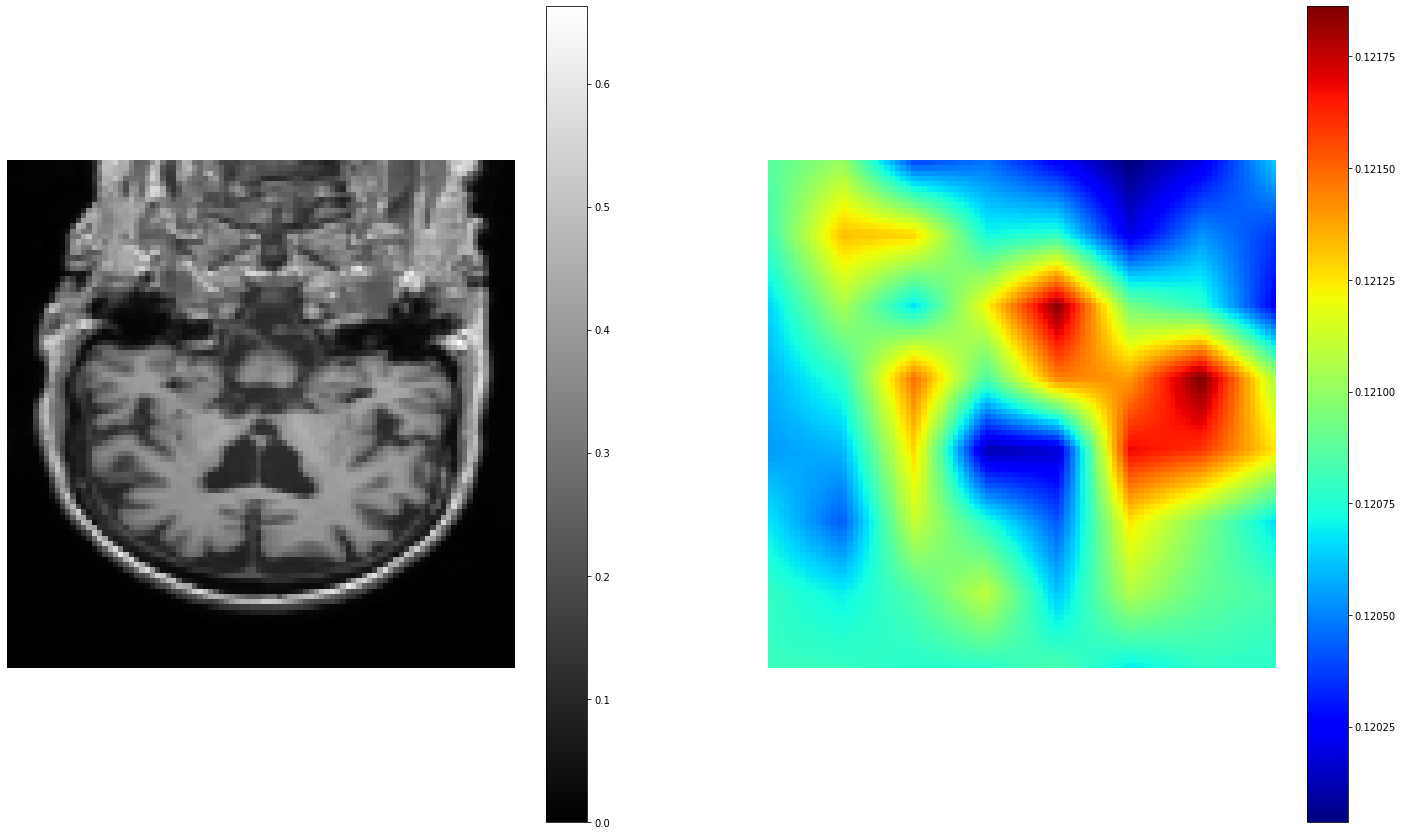

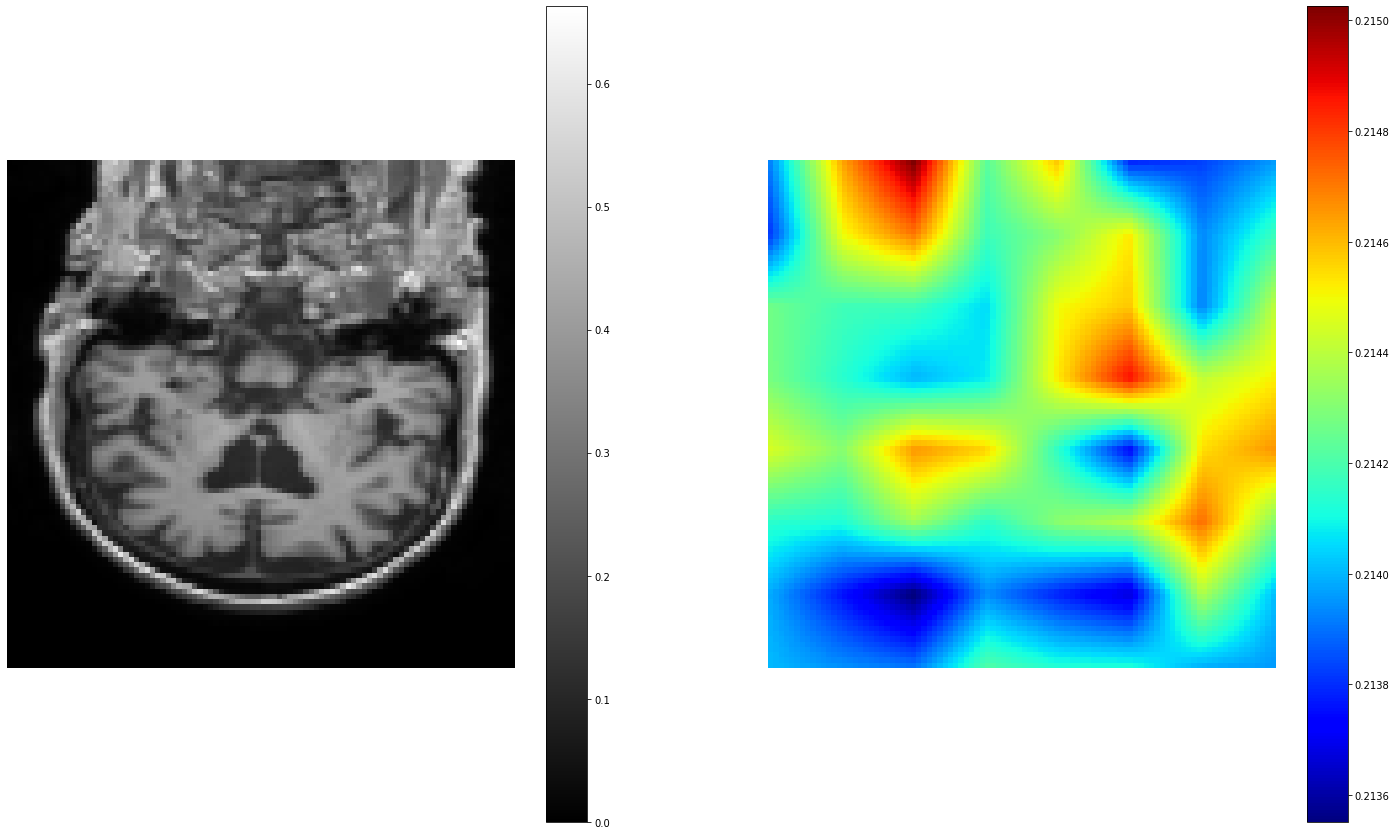

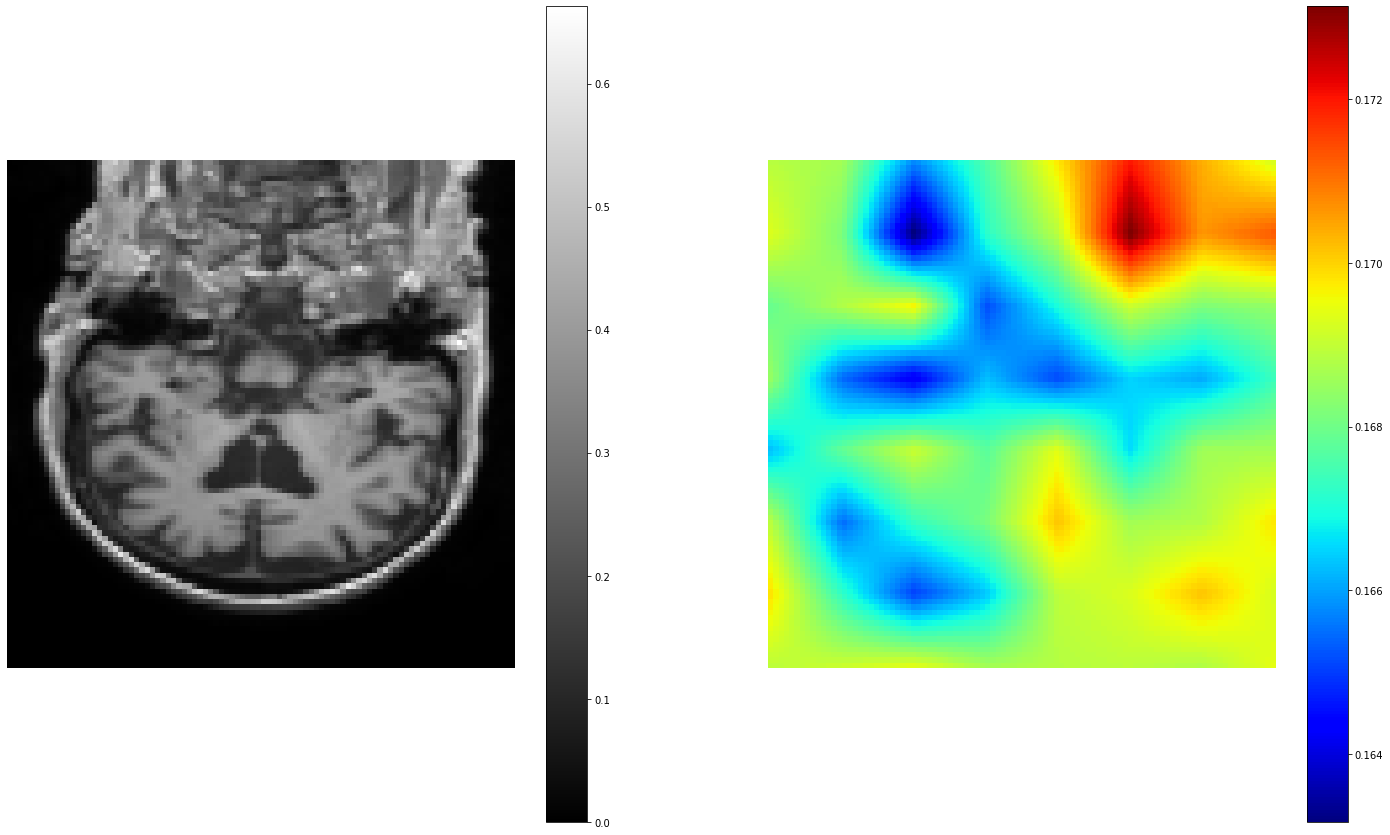

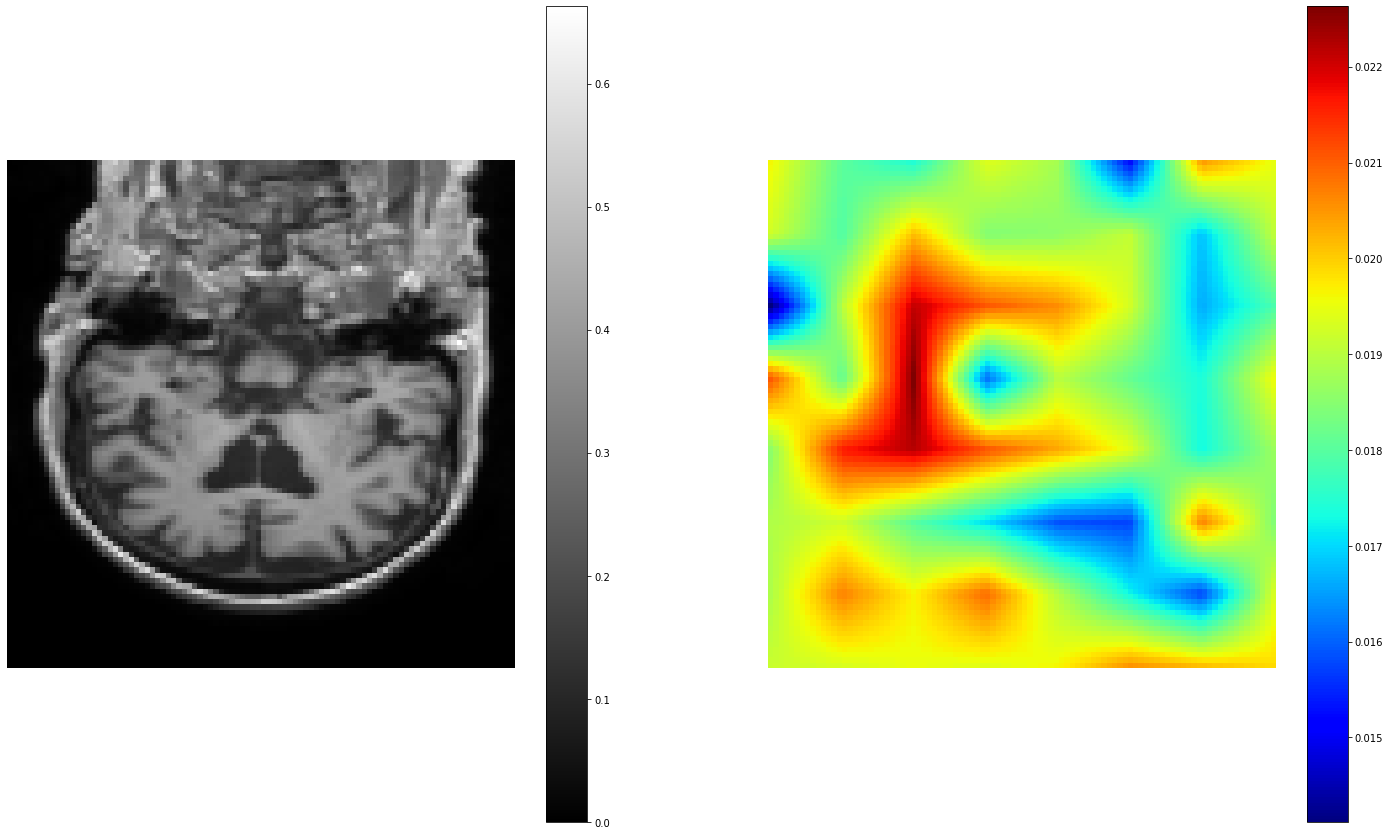

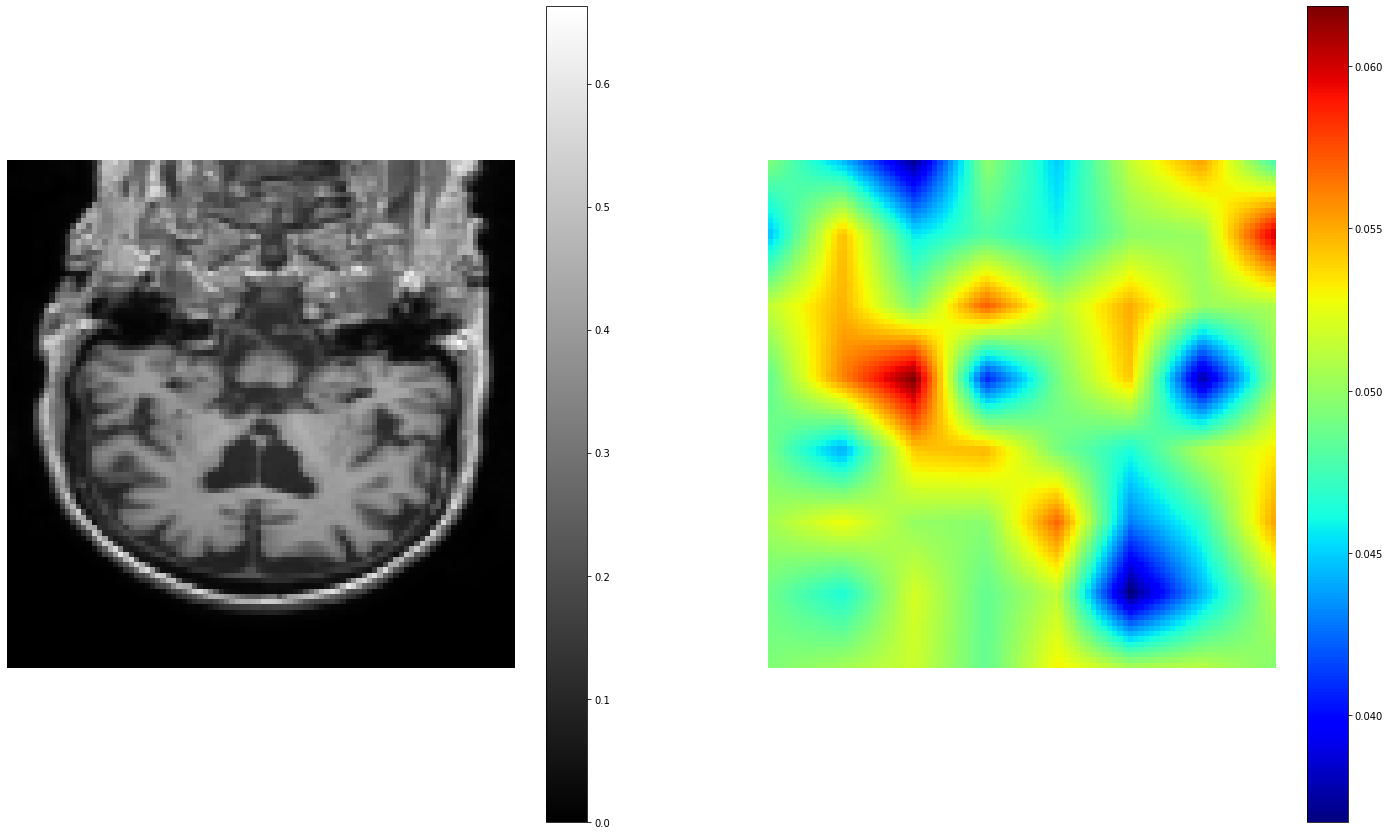

In [15]:
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device) #,dropout_prob=0.5
model_names=[x for x in os.listdir() if 'best_metric' in x]

for j in model_names:
  print(j)
  model.load_state_dict(torch.load(os.path.join(root_dir, j))) #grab random model name

  # Get the occlusion sensitivity map - more info in https://docs.monai.io/en/stable/visualize.html
  occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10, stride=12)
  # mask_size – Size of box to be occluded, centred on the central voxel. To ensure that the occluded area is correctly centred, mask_size and stride should both be odd or even.
  # n_batch – Number of images in a batch for inference.
  # stride  – Stride in spatial directions for performing occlusions.

  # Only get a single slice to save time.
  # For the other dimensions (channel, width, height), use
  # -1 to use 0 and img.shape[x]-1 for min and max, respectively
  depth_slice = img.shape[2] // 2
  occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

  occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
  print(occ_result)
  occ_result = occ_result[..., label.argmax().item()]

  fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

  for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
      cmap = "gray" if i == 0 else "jet"
      ax = axes[i]
      im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
      ax.axis("off")
      fig.colorbar(im_show, ax=ax)

  wandb.init()
  wandb.log({"occlusion_sensitivity"+str(j): fig}) #Saved in last experiment 'Runs'/Files/media/images

## Cleanup data directory (Colab)

In [16]:
ls

best_metric_model_classification3d_arrayadam4.pth  modeladam5.onnx
best_metric_model_classification3d_arrayadam5.pth  modeladam6.onnx
best_metric_model_classification3d_arrayadam6.pth  modelsgd4.onnx
best_metric_model_classification3d_arraysgd4.pth   modelsgd6.onnx
best_metric_model_classification3d_arraysgd6.pth   nsourlos/
ixi/                                               runs/
ixi.tar                                            sample_data/
modeladam4.onnx                                    wandb/


In [17]:
wandb.finish()

In [18]:
model_onnx=[x for x in os.listdir() if 'onnx' in x]
for onnx_model in model_onnx:
  os.remove(onnx_model)

for pth in model_names:
  os.remove(pth)

os.remove("ixi.tar")
shutil.rmtree("ixi") 

In [19]:
ls

nsourlos/  runs/  sample_data/  wandb/
